# TD3 - Maxime Corda

In [ ]:
import plotly
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as clr
import matplotlib.animation as animation
from tqdm import tqdm
import plotly.graph_objects as go
import plotly.express as px
from matplotlib.lines import Line2D
from scipy.signal import fftconvolve
from sklearn.svm import LinearSVC
from itertools import *
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from sklearn import linear_model

!git clone https://github.com/HNinou/MathTools_TD2
!unzip MathTools_TD2/dic_cont8_GO.npy.zip -d MathTools_TD2/

Cloning into 'MathTools_TD2'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 10 (delta 1), reused 10 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (10/10), 16.96 MiB | 13.66 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Archive:  MathTools_TD2/dic_cont8_GO.npy.zip
  inflating: MathTools_TD2/dic_cont8_GO.npy  
  inflating: MathTools_TD2/__MACOSX/._dic_cont8_GO.npy  


# Performing PCA on neural data


In [ ]:
def gaussian(x, sigma, mu=0):
    return np.exp(-((x-mu)**2) / (2*sigma**2))

def make_conv_kernel( sigma= 30):
    nb_time_frames = 6*sigma
    conv_kernel = gaussian(np.arange(-nb_time_frames//2,nb_time_frames//2,1), sigma=sigma)
    conv_kernel /= np.sum(conv_kernel)

    return conv_kernel

def smoothen_data(dic, sigma=30):
    # Get number of neurons
    nb_neurons = len(dic['mat'])

    # Create the convolution kernel
    conv_kernel = make_conv_kernel(sigma=sigma)

    # Pre-allocate the smooth_mat with the same structure as dic['mat']
    smooth_mat = [None] * nb_neurons

    # Loop over neurons, but vectorize across trials
    for neuron in range(nb_neurons):
        # Get all trials for this neuron as a 2D matrix (nb_trials, time_points)
        mat_neuron = dic['mat'][neuron]

        # Use fftconvolve for faster convolution across all trials
        smooth_neuron = fftconvolve(mat_neuron, conv_kernel[None, :], mode='same', axes=1)

        # Store the result back
        smooth_mat[neuron] = smooth_neuron

    # Replace the original matrix with the smoothed data
    dic['sm_mat'] = smooth_mat
    return dic


def raster_plot(neural_data):
  # Create the raster plot using Plotly
  fig = go.Figure(data=go.Heatmap(
      z=neural_data,
      colorscale='Greys',
      colorbar=dict(
          title="Neural Activity",
          titleside='right',
          ticks='outside',
          ticklen=5,
          tickcolor='black',
      )
  ))

  fig.update_layout(
      title="Neural Activity Raster Plot",
      xaxis=dict(
          title="Time (ms)",
          ticks='outside',
          showline=True,
          linewidth=2,
          linecolor='black',
          mirror=True
      ),
      yaxis=dict(
          title="Trial Index",
          ticks='outside',
          showline=True,
          linewidth=2,
          linecolor='black',
          mirror=True
      ),
      plot_bgcolor='white',
      font=dict(size=14),
  )

  # Display the plot
  fig.show()
  return()

The cell below stores the data in the dictionnary dic_cont8. The raw data is stored in dic_cont8['mat'] which is a list of size 777, that is the total number of neurons. Each element of this list contains a matrix of size (#trials x #timesteps). For each recording, that is for each trial, the data is shifted so that the 'GO' signal always shows up at the 2000th time frame.

In [ ]:
# Load the data from the .npy files

centering = 'GO'
dic_cont8 =np.load('MathTools_TD2/dic_cont8_GO.npy', allow_pickle = True).flat[0]
# Smooth the data using a Gaussian filter with a sigma of 100
dic_cont8 = smoothen_data(dic_cont8, sigma=100)

nb_neurons = len(dic_cont8['target'])

nb_trials_cont8 = np.zeros(nb_neurons)
for i in range(nb_neurons):
    nb_trials_cont8[i] = dic_cont8['target'][i].shape[0]

In [ ]:
nb_neurons= len(dic_cont8['mat'])
nb_trials = []
for n in range(nb_neurons):
    nb_trials.append(dic_cont8['mat'][n].shape[0])
nb_trials = np.array(nb_trials)


Let's store the number of trials per neuron for each of the 8 targets

In [ ]:
nb_neurons= len(dic_cont8['mat'])
nb_trials_per_c = np.zeros((8,nb_neurons))
for k,target in enumerate(range(1,9)):
  for n in range(nb_neurons):
    nb_trials_per_c[k, n] = dic_cont8['mat'][n][dic_cont8['target'][n]==target].shape[0]


# 1) Fill in the cell below

In [ ]:
neuron_filter_ct = np.zeros(nb_neurons) == 0

for n in range(nb_neurons):
  for target in range(1,9):
    if (dic_cont8['target'][n] == target).sum() < 20 :
        neuron_filter_ct[n] = False

In [ ]:
neuron_filter_ct.sum()

245

There are 245 neurons fulfilling this condition.

In [ ]:
# put the 10 first trials in the training set and the 2 last in the testing set

X = []
for n in range(nb_neurons):
    if neuron_filter_ct[n]:
        res = []
        for target in range(1,9):
            filter_res = np.where(dic_cont8['target'][n] == target)[0][:20]
            res.append(dic_cont8['sm_mat'][n][filter_res][:,1700:1701].mean(axis = 0).flatten())

        res = np.array(res)

        X.append(res.flatten())


X = np.array(X)

X -= X.mean(axis = 1)[:,None]

In [ ]:
C = X@X.T/neuron_filter_ct.sum()
eigval, eigvec = np.linalg.eigh(C)

In [ ]:
colors = np.zeros(400*8)
for target in range(8):
    colors[target:(target+1)] = target/7

fig = go.Figure()

# Add a 3D scatter plot with PC1, PC2, and PC3 as axes
fig.add_trace(go.Scatter3d(
    x=(eigvec[:,-1]  @ X),
    y=(eigvec[:,-2]  @ X),
    z=(eigvec[:,-3]  @ X),
    mode='markers',
    marker=dict(size = 10,
                  colorscale = 'Rainbow',
                  color = colors,
                  colorbar = dict(title ='Target',
                                  titleside = 'top',
                                  tickvals = np.linspace(0,1,8),
                                  ticktext=['1','2','3','4','5','6','7','8'],
                                  orientation = 'h',
                                  len = 0.3,
                                  x=0.8,
                                  y=0.9)),
    hovertemplate='X: %{x:.2f}<br>Y: %{y:.2f}<br>Z: %{z:.2f}<br>Intensity: %{marker.color:.2f}'
))

# Update layout for scientific journal-quality
fig.update_layout(
    title={
        'text': "Projection of the data on the first three principal components",
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    scene=dict(
        xaxis=dict(
            title="PC1",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
        yaxis=dict(
            title="PC2",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
        zaxis=dict(
            title="PC3",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
    ),
    font=dict(
        family="Times New Roman, serif",
        size=12,
        color="black"
    ),
    margin=dict(l=80, r=40, t=80, b=80),
    paper_bgcolor="white",
    plot_bgcolor="white",
    legend=dict(
        title="Legend",
        orientation="h",
        yanchor="top",
        y=1.02,
        xanchor="center",
        x=0.5
    ),
    width=800,
    height=800
)

# Display the plot
fig.show()


Variance explained by the 3 first PCs ?

In [ ]:
eigval[-3:].sum()/eigval.sum()

0.9115596642605297

The 3 first PCs explain 91% of the variance.

# 1.c)How are the neural states arranged in the 3D PCA representation?
They form eight distinct clusters (one per target), although there may be slight overlap.


# 1.d) What is the variance explained by the first 3 PCs?

eigval[-3:].sum()/eigval.sum() gives approximately 0.91 (91%) of the total variance.

# 2.a)b) SEE SCAN PDF ATTACHED

# 3)

# 3.a) SEE SCAN PDF ATTACHED

The cells below formats our data to build the targets and predictors of the training and testing sets.

In [ ]:
nb_trials_train = 16
nb_trials_test = 4
nb_valid_neurons = neuron_filter_ct.sum()
t_start = 1700
t_end = 1701

In [ ]:
def get_XY_train_test():

    # put the 16 first trials in the training set and the 4 last in the testing set

    X_train = []
    X_test = []
    for n in range(nb_neurons):
        if neuron_filter_ct[n]:
            res_train = []
            res_test = []
            for target in range(1,9):
                #Get all indices for the current target
                target_indices = np.where(dic_cont8['target'][n] == target)[0]

                # Perform a train-test split to get 16 training and 4 testing trials
                train_indices, test_indices = train_test_split(target_indices, test_size=4, train_size=16)

                # Append the corresponding data slices for training and testing
                res_train.append(dic_cont8['sm_mat'][n][train_indices][:, t_start:t_end])
                res_test.append(dic_cont8['sm_mat'][n][test_indices][:, t_start:t_end])


            res_train = np.array(res_train)
            res_test = np.array(res_test)

            X_train.append(res_train)
            X_test.append(res_test)


    X_train = np.array(X_train)
    X_test = np.array(X_test)

    X_train -= X_train.reshape((nb_valid_neurons,-1)).mean(axis =1)[:,None,None,None]
    X_test -= X_test.reshape((nb_valid_neurons,-1)).mean(axis =1)[:,None,None,None]

    X_train = X_train.swapaxes(0,2)
    X_train = X_train.swapaxes(0,1)
    X_train = X_train.reshape((8*nb_trials_train, nb_valid_neurons*(t_start-t_end)))

    X_test = X_test.swapaxes(0,2)
    X_test = X_test.swapaxes(0,1)
    X_test = X_test.reshape((8*nb_trials_test, nb_valid_neurons*(t_start-t_end)))

    Y1 = np.cos( np.arange(8)[:,None] * np.ones(nb_trials_train) * 2*np.pi/8).reshape(8*nb_trials_train)
    Y2 = np.sin( np.arange(8)[:,None] * np.ones(nb_trials_train) * 2*np.pi/8).reshape(8*nb_trials_train)
    Y_train = np.column_stack((Y1,Y2))

    Y1_test = np.cos( np.arange(8)[:,None] * np.ones(nb_trials_test) * 2*np.pi/8).reshape(8*nb_trials_test)
    Y2_test = np.sin( np.arange(8)[:,None] * np.ones(nb_trials_test) * 2*np.pi/8).reshape(8*nb_trials_test)
    Y_test = np.column_stack((Y1_test,Y2_test))

    return X_train, X_test, Y_train, Y_test


In [ ]:
X_train, X_test, Y_train, Y_test = get_XY_train_test()

print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

(128, 245) (32, 245)
(128, 2) (32, 2)


# 4)

In [ ]:
inv_mat = np.linalg.inv(X_train.T@X_train)

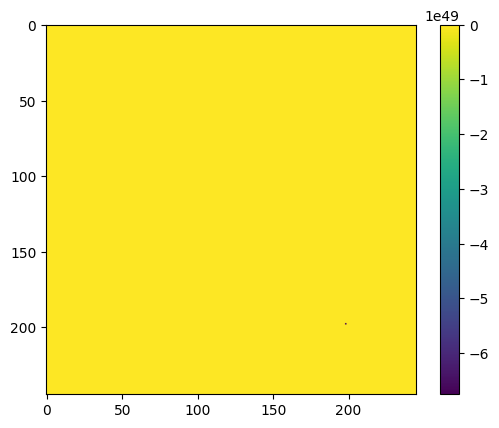

In [ ]:
plt.imshow(inv_mat)
plt.colorbar()

# 4.b) What issue arises with the matrix $ X^{T}_{train}.X_{train} $ ?
 the direct inversion of $ X^{T}_{train}.X_{train} $ is not possible here, we should use regularization or compute the pseudo-inverse to fix this issue.

# 5) What method would you suggest to compute the coefficients in this case?

Use regularization methods, such as Ridge or Lasso, which avoid inverting a potentially ill-conditioned matrix directly.

# 6) How could you modify $ X^{T}.X $ to ensure it has linearly independent columns?

By adding a small constant $ \alpha $ to the diagonal:
$ X^{T}.X → X^{T}.X + \alpha . I $.
This is exactly the Ridge Regression approach.

# 7)

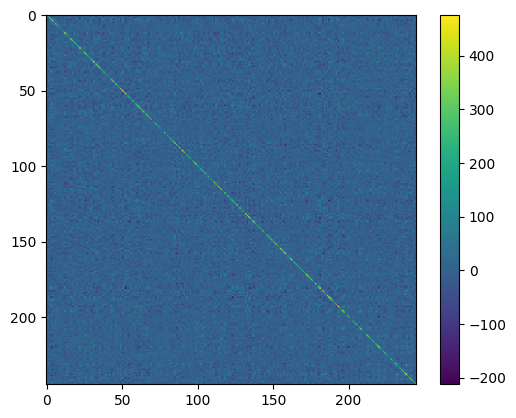

In [ ]:
pinv_mat = np.linalg.pinv(X_train.T@X_train)
plt.imshow(pinv_mat)
plt.colorbar()

From now on, we will use the built in functions from scikit learn to implement our models.
The cell below builds a linear regression model with biases and fits the coefficients to the training data.

In [ ]:
linreg_model = linear_model.LinearRegression(fit_intercept=True) ### use sklearn lib
linreg_model.fit(X_train, Y_train)

LinearRegression()

The cell below evaluates the performance of the learned model on the test data.

In [ ]:
def degrees(Y):

  deg = np.degrees(np.arctan2(Y[:, 1], Y[:, 0]))
  deg = (deg + 360) % 360  #degrees [0, 360[
  return deg

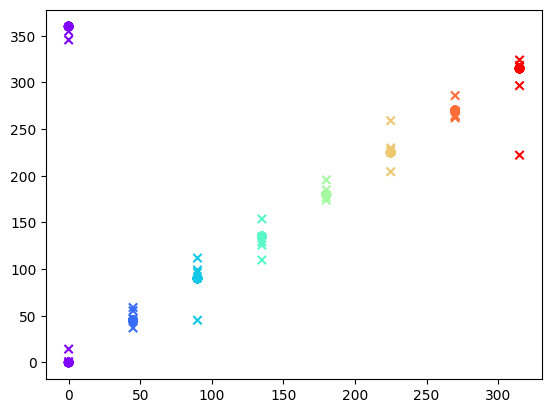

In [ ]:
colors_train = (np.arange(8)[:,None]*np.ones(nb_trials_train)).reshape(8*nb_trials_train)
colors_test =  (np.arange(8)[:,None]*np.ones(nb_trials_test)).reshape(8*nb_trials_test)

Y_train_predicted = linreg_model.predict(X_train)
Y_test_predicted = linreg_model.predict(X_test)


plt.scatter(degrees(Y_train), degrees(Y_train_predicted), c = colors_train, cmap = 'rainbow' )
plt.scatter(degrees(Y_test), degrees(Y_test_predicted), c = colors_test, cmap = 'rainbow', marker = 'x')


# 7.b) Comment on the results of linear regression on both training and testing sets.

- On the training set, predicted angles vs. actual angles lie close to the diagonal, indicating a good fit.
- On the testing set, there is more scatter, showing the model’s generalization error. This suggests some overfitting but still a clear correlation between predicted and true directions.


# 8) Does increasing $ \alpha $ in Ridge regression increase or decrease model complexity?
Increasing $ \alpha $ decreases model complexity: it places a stronger penalty on large coefficients, and so shrinks them more, reducts overfitting.

# 9)

In [1]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

def perform_kfold_validation(model, X, Y, k=8):

  kf = KFold(n_splits=k, shuffle=True) # Setting a random_state
  scores = []

  for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]


    model.fit(X_train, Y_train)
    score = model.score(X_val,Y_val)
    scores.append(score)

  return scores

score_linreg = np.zeros(100)

for i in range(100):
  scores = perform_kfold_validation(LinearRegression(fit_intercept=True), X_train, Y_train, k=5)
  score_linreg[i] = np.mean(scores)

KeyboardInterrupt: 

In [ ]:
score_linreg.mean()

# 10)

This can take a while

In [ ]:
# score_linreg = np.zeros(100)

from sklearn.linear_model import Ridge

alpha_list = np.logspace(-6, -1, 50)
score_ridge = np.zeros((100,50))

for alpha in alpha_list:
  for i in range(100):
    scores = perform_kfold_validation(Ridge(alpha=alpha, fit_intercept=True), X_train, Y_train, k=5)
    score_ridge[i,np.where(alpha_list == alpha)] = np.mean(scores)

# 11)

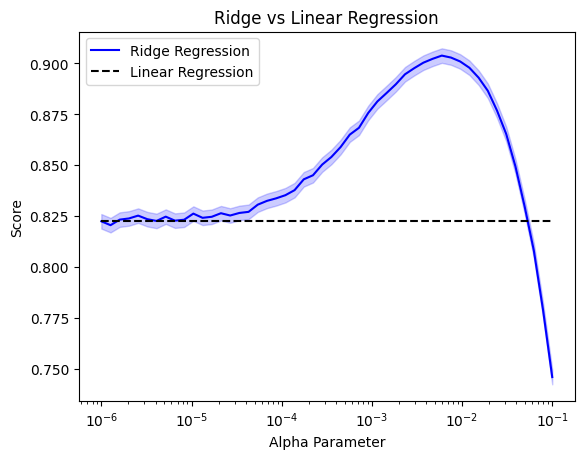

In [ ]:
# Compute means and standard errors
ridge_mean = score_ridge.mean(axis = 0)
ridge_sem = score_ridge.std() / np.sqrt(score_ridge.shape[0])  # ! this is the standard error not the STD!
linreg_mean = score_linreg.mean()

# Plot Ridge Regression with shaded error area
plt.plot(alpha_list, ridge_mean, label='Ridge Regression', color='blue')
plt.fill_between(alpha_list, ridge_mean - ridge_sem, ridge_mean + ridge_sem, color='blue', alpha=0.2)

# Plot Linear Regression as a horizontal line
plt.hlines(y=linreg_mean, xmin=alpha_list[0], xmax=alpha_list[-1], color='black', linestyle='--', label='Linear Regression')

# Set x-axis to logarithmic scale
plt.xscale('log')

# Add labels, legend, and show the plot
plt.xlabel("Alpha Parameter")
plt.ylabel("Score")
plt.legend()
plt.title("Ridge vs Linear Regression")
plt.show()

# 12)

In [ ]:
opt_alpha = alpha_list[np.argmax(ridge_mean)]
print('optimal alpha = ', opt_alpha)

optimal alpha =  0.005963623316594642


In [ ]:
X_train, X_test, Y_train, Y_test = get_XY_train_test()
ridge_model = Ridge(alpha=opt_alpha, fit_intercept=True)
ridge_model.fit(X_train, Y_train)

Ridge(alpha=0.005963623316594642)

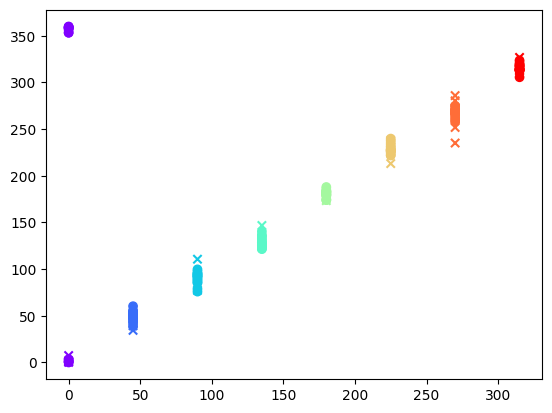

In [ ]:
colors_train = (np.arange(8)[:,None]*np.ones(nb_trials_train)).reshape(8*nb_trials_train)
colors_test =  (np.arange(8)[:,None]*np.ones(nb_trials_test)).reshape(8*nb_trials_test)

Y_train_predicted = ridge_model.predict(X_train)
Y_test_predicted = ridge_model.predict(X_test)

plt.scatter(degrees(Y_train), degrees(Y_train_predicted), c = colors_train, cmap = 'rainbow')
plt.scatter(degrees(Y_test), degrees(Y_test_predicted) , c = colors_test, cmap = 'rainbow', marker = 'x')

# 12.a) What is the optimal $ \alpha $ for Ridge Regression?

We found $\alpha$ ≈ 0.0059636.

#12.c) Comment on the results of the optimal Ridge model.

Ridge regression shows reduced overfitting compared to linear regression.
The predictions on the test set align with the actual angles, often better than unregularized linear regression.

# 13)

# Implement the Lasso regression model with parameter 𝛼 = 10−4 and print the coefficients.

In [ ]:
from sklearn.linear_model import Lasso
lasso_model = Lasso(alpha=1e-4, fit_intercept=True)
lasso_model.fit(X_train, Y_train)

#Coefficients from ridge and lasso models
ridge_coefficients = ridge_model.coef_
lasso_coefficients = lasso_model.coef_

print("Coefficients for the Lasso regression model (alpha = 10^(-4)) : ", lasso_model.coef_)

Coefficients for the Lasso regression model (alpha = 10^(-4)) :  [[ 0.00000000e+00  2.33103682e+00 -0.00000000e+00 -0.00000000e+00
   0.00000000e+00  3.51809627e+00  0.00000000e+00 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  3.74287479e+00  0.00000000e+00
   0.00000000e+00 -0.00000000e+00  2.67568763e+00 -0.00000000e+00
  -8.56009629e+00  0.00000000e+00 -0.00000000e+00 -5.86687448e-01
  -3.48184325e-01  0.00000000e+00 -0.00000000e+00  0.00000000e+00
   0.00000000e+00 -1.13255671e+00 -0.00000000e+00 -9.11982167e-01
   0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.01241163e+00
   1.36650313e+00  1.42979800e+01 -0.00000000e+00 -0.00000000e+00
   0.00000000e+00  4.12260710e+00  3.55200847e+00 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  3.96579066e+00
  -0.00000000e+00  1.75871911e-02 -0.00000000e+00 -2.88058049e+00
  -0.000000

# 13.b) What major difference do you observe in the Lasso coefficients compared to Ridge?
Lasso drives some coefficients exactly to zero, resulting in a sparser solution. Ridge shrinks coefficients but does not force them fully to reach zero.



# 14)

This can take a while

In [ ]:
score_linreg = np.zeros(100)

for i in range(100):
  scores = perform_kfold_validation(LinearRegression(fit_intercept=True), X_train, Y_train, k=5)
  score_linreg[i] = np.mean(scores)

alpha_list = np.logspace(-5, -3, 50)
score_ridge = np.zeros((100,50))

for alpha in alpha_list:
  for i in range(100):
    ridge_model = Ridge(alpha=alpha, fit_intercept=True)
    scores = perform_kfold_validation(ridge_model, X_train, Y_train, k=5)
    score_ridge[i,np.where(alpha_list == alpha)] = np.mean(scores)



alpha_lasso_list = np.logspace(-5, -3, 50)
score_lasso = np.zeros((100, 50))

for alpha in alpha_lasso_list:
    for i in range(100):
        lasso_model = Lasso(alpha=alpha, fit_intercept=True, max_iter = 10000)
        scores = perform_kfold_validation(lasso_model, X_train, Y_train, k=5)
        score_lasso[i, np.where(alpha_lasso_list == alpha)] = np.mean(scores)



In [ ]:
opt_lasso_alpha = alpha_lasso_list[np.argmax(score_lasso.mean(axis=0))]

print('optimal alpha = ', opt_lasso_alpha)

optimal alpha =  0.00011513953993264469


#14.b) What is the optimal $\alpha$ for Lasso regression?

From the precedent cross-validation:

$\alpha ≈ 1.15 × 10^{-4}$

# 15)

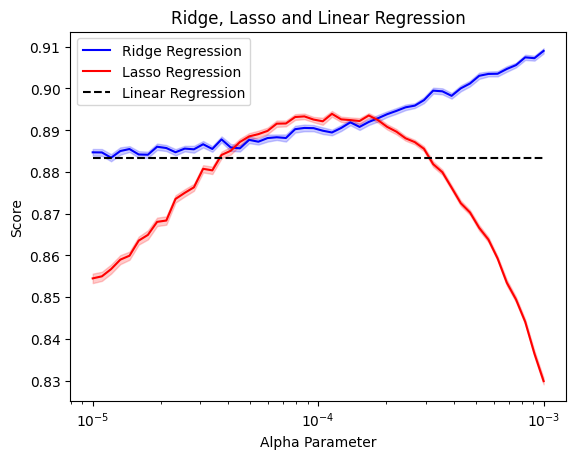

In [ ]:
# Compute means and standard errors
ridge_mean = score_ridge.mean(axis=0)
ridge_sem = score_ridge.std(axis =0)/ np.sqrt(score_ridge.shape[0]) # ! this is the standard error not the STD!
lasso_mean = score_lasso.mean(axis=0)
lasso_sem = score_lasso.std(axis=0) / np.sqrt(score_lasso.shape[0]) # ! this is the standard error not the STD!
linreg_mean = score_linreg.mean()

# Plot Ridge Regression with shaded error area
plt.plot(alpha_list, ridge_mean, label='Ridge Regression', color='blue')
plt.fill_between(alpha_list, ridge_mean - ridge_sem, ridge_mean + ridge_sem, color='blue', alpha=0.2)

# Plot Lasso Regression with shaded error area
plt.plot(alpha_lasso_list, lasso_mean, label='Lasso Regression', color='red')
plt.fill_between(alpha_lasso_list, lasso_mean - lasso_sem, lasso_mean + lasso_sem, color='red', alpha=0.2)


# Plot Linear Regression as a horizontal line
plt.hlines(y=linreg_mean, xmin=alpha_list[0], xmax=alpha_list[-1], color='black', linestyle='--', label='Linear Regression')

# Set x-axis to logarithmic scale
plt.xscale('log')

# Add labels, legend, and show the plot
plt.xlabel("Alpha Parameter")
plt.ylabel("Score")
plt.legend()
plt.title("Ridge, Lasso and Linear Regression")
plt.show()

#15) Compare the cross-validation results of Lasso regression with Ridge regression and standard linear regression.

From the dashed line, linear regression stands at around 0.88.
At its best $\alpha$ Ridge reaches 0.91, while Lasso reaches 0.89 but eventually drops below 0.85 for larger $\alpha$.

Thus, both regularization methods can exceed linear regression when $\alpha$ is well-chosen, with Ridge achieving the highest score here in this dataset.